# 데이터 로드

In [1]:
# manipulated
import gdown

url = "https://drive.google.com/uc?id=1Dy8OjqVSQ4gvZiF70LruptrjccgIm9J3"
gdown.download(url,'/content/manipulated.zip',quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Dy8OjqVSQ4gvZiF70LruptrjccgIm9J3
From (redirected): https://drive.google.com/uc?id=1Dy8OjqVSQ4gvZiF70LruptrjccgIm9J3&confirm=t&uuid=dc8a2f20-8215-4e84-a20e-2251cc5210df
To: /content/manipulated.zip
100%|██████████| 3.58G/3.58G [00:33<00:00, 105MB/s]


'/content/manipulated.zip'

In [2]:
!unzip -q /content/manipulated.zip -d /content

In [3]:
# original

url = "https://drive.google.com/uc?id=1F3NvAGSz-6kDY5SPZjZy6wZYE89iemD4"
gdown.download(url,'/content/original.zip',quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1F3NvAGSz-6kDY5SPZjZy6wZYE89iemD4
From (redirected): https://drive.google.com/uc?id=1F3NvAGSz-6kDY5SPZjZy6wZYE89iemD4&confirm=t&uuid=4337bcb7-a248-44f3-8568-251c0acd2c18
To: /content/original.zip
100%|██████████| 435M/435M [00:04<00:00, 98.3MB/s]


'/content/original.zip'

In [4]:
!unzip -q /content/original.zip -d /content

In [5]:
!mv /content/DFD_manipulated_sequences /content/manipulated

In [6]:
!mv "/content/DFD_original sequences" "/content/original"

# 모델 구현

In [7]:
# ------------------ 0. Import (필수) ------------------
import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

In [8]:
# ------------------ 1. 데이터셋 클래스 ------------------
class DeepfakeSeqDataset(Dataset):
    def __init__(self, root_dir, frame_num=72, size=299, face_count_filter=None):
        """
        frame_num: 시퀀스 길이(프레임 수)
        size: 프레임 이미지 크기 (Xception은 299)
        face_count_filter: None(전체), 1(1명), 2(2명 이상)
        """
        self.data = []
        self.labels = []
        self.video_face_count = {}
        self.frame_num = frame_num
        self.size = size

        # XceptionNet mean/std로 정규화
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Xception은 공식적으로 [0.5,0.5,0.5], [0.5,0.5,0.5] (논문/공식코드 참고)
        ])

        for label, subdir in enumerate(['original', 'manipulated']):
            sub_path = os.path.join(root_dir, subdir)
            video_dict = {}
            for img_path in glob.glob(os.path.join(sub_path, "*.jpg")):
                fname = os.path.basename(img_path)
                main, ext = os.path.splitext(fname)
                parts = main.split('_')
                if len(parts) < 3:
                    continue
                try:
                    face_idx = int(parts[-1])
                    fnum = int(parts[-2])
                except ValueError:
                    continue
                video_id = '_'.join(parts[:-2])
                if video_id not in video_dict:
                    video_dict[video_id] = {}
                if face_idx not in video_dict[video_id]:
                    video_dict[video_id][face_idx] = {}
                video_dict[video_id][face_idx][fnum] = img_path

            # 비디오별 face 개수 필터링
            for video_id, people_dict in video_dict.items():
                face_count = len(people_dict)
                self.video_face_count[video_id] = face_count
                if face_count_filter is not None:
                    if face_count_filter == 1 and face_count != 1:
                        continue
                    elif face_count_filter == 2 and face_count < 2:
                        continue
                for face_idx, frame_dict in people_dict.items():
                    # **시퀀스 길이가 부족하면 패딩 또는 스킵**
                    if len(frame_dict) == self.frame_num:
                        frame_files = [frame_dict[fidx] for fidx in range(self.frame_num)]
                        self.data.append((video_id, face_idx, frame_files))
                        self.labels.append(label)
                    # 패딩 예시:
                    # else:
                    #     frame_list = [frame_dict[fidx] if fidx in frame_dict else None for fidx in range(self.frame_num)]
                    #     self.data.append((video_id, face_idx, frame_list))
                    #     self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_id, face_idx, frames = self.data[idx]
        label = self.labels[idx]
        imgs = []
        for img_path in frames:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.size, self.size))
            img = self.transform(img)  # (3, size, size)
            imgs.append(img)
        imgs = torch.stack(imgs, dim=0)  # (T, 3, size, size)
        # XceptionNet에 프레임별로 (batch, 3, size, size) 형태로 넣을 예정 → LSTM은 (T, feat_dim)
        return imgs, label, video_id, face_idx

In [9]:
# 2. 데이터 분할
root_dir = '/content'
dataset_1face = DeepfakeSeqDataset(root_dir, frame_num=72, size=299, face_count_filter=1)
indices = np.arange(len(dataset_1face))
labels = [dataset_1face.labels[i] for i in range(len(dataset_1face))]
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)
train_set = Subset(dataset_1face, train_idx)
val_set = Subset(dataset_1face, val_idx)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False, num_workers=2)
# 2명 이상 비디오 (test용)
dataset_2face = DeepfakeSeqDataset(root_dir, frame_num=72, size=299, face_count_filter=2)
test_loader = DataLoader(dataset_2face, batch_size=2, shuffle=False, num_workers=2)


In [10]:
# 3. XceptionNet+LSTM 모델 정의
class XceptionLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=1, num_classes=2):
        super().__init__()
        # Pretrained XceptionNet (torchvision 공식에는 없음)
        # pretrained_weights = ... (본인 환경에 따라 불러오거나 직접 XceptionNet 구현)
        # 여기선 EfficientNetV2나 InceptionV3, 혹은 timm 라이브러리 활용
        import timm
        self.xcp = timm.create_model('xception', pretrained=True, num_classes=0) # features만 추출
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (B, T, 3, 299, 299)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # (B*T, 3, 299, 299)
        feats = self.xcp(x)         # (B*T, 2048)
        feats = feats.view(B, T, -1)  # (B, T, 2048)
        out, (hn, cn) = self.lstm(feats) # (B, T, hidden)
        # LSTM 마지막 스텝만 사용
        out = out[:, -1, :]  # (B, hidden)
        logits = self.fc(out)
        return logits


In [11]:
# 4. Loss, optimizer
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        BCE = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE
        return F_loss.mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XceptionLSTM(hidden_size=256, num_layers=1, num_classes=2).to(device)
criterion = FocalLoss(alpha=0.1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [13]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, average_precision_score
from torch.nn.functional import softmax

In [14]:
# 5. 학습/평가 루프
num_epochs = 30
patience = 10
best_auc = 0
pat = 0
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': [],
    'train_auc': [], 'val_auc': [],
    'train_prc': [], 'val_prc': [],
    'train_prec': [], 'val_prec': [],
    'train_rec': [], 'val_rec': [],
    'train_mcc': [], 'val_mcc': []
}


for epoch in range(num_epochs):
    # --- Train ---
    model.train()
    train_loss, preds, targets, probs = [], [], [], []
    for frames, label, video_id, face_idx in tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]'):
        frames = frames.to(device)        # (B, T, 3, 299, 299)
        label = label.to(device)
        optimizer.zero_grad()
        out = model(frames)               # (B, 2)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        prob = softmax(out, dim=-1)[:, 1].detach().cpu().numpy()
        pred_label = (prob > 0.4).astype(int)
        preds += list(pred_label)
        targets += list(label.cpu().numpy())
        probs += list(prob)
    train_loss = np.mean(train_loss)
    train_acc = accuracy_score(targets, preds)
    train_f1 = f1_score(targets, preds)
    train_auc = roc_auc_score(targets, probs)
    train_prc = average_precision_score(targets, probs)
    train_prec = precision_score(targets, preds)
    train_rec = recall_score(targets, preds)
    train_mcc = matthews_corrcoef(targets, preds)

    # --- Validation ---
    model.eval()
    val_loss, preds, targets, probs = [], [], [], []
    val_video_ids, val_face_idxs = [], []
    with torch.no_grad():
        for frames, label, video_id, face_idx in tqdm(val_loader, desc=f'Epoch {epoch+1} [Val]'):
            frames = frames.to(device)
            label = label.to(device)
            out = model(frames)
            loss = criterion(out, label)
            val_loss.append(loss.item())
            prob = softmax(out, dim=-1)[:, 1].cpu().numpy()
            pred_label = (prob > 0.4).astype(int)
            preds += list(pred_label)
            targets += list(label.cpu().numpy())
            probs += list(prob)
            if isinstance(video_id, (list, tuple)):
                val_video_ids += list(video_id)
                val_face_idxs += list(face_idx)
            else:
                val_video_ids.append(video_id)
                val_face_idxs.append(face_idx)
    val_loss = np.mean(val_loss)
    val_acc = accuracy_score(targets, preds)
    val_f1 = f1_score(targets, preds)
    val_auc = roc_auc_score(targets, probs)
    val_prc = average_precision_score(targets, probs)
    val_prec = precision_score(targets, preds)
    val_rec = recall_score(targets, preds)
    val_mcc = matthews_corrcoef(targets, preds)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    history['train_mcc'].append(train_mcc)
    history['val_mcc'].append(val_mcc)

    print(
        f"[{epoch+1}]"
        f"\n  train_loss={train_loss:.4f}, val_loss={val_loss:.4f}"
        f"\n  train_acc={train_acc:.4f}, val_acc={val_acc:.4f}"
        f"\n  train_f1={train_f1:.4f}, val_f1={val_f1:.4f}"
        f"\n  train_auc={train_auc:.4f}, val_auc={val_auc:.4f}"
        f"\n  train_prc={train_prc:.4f}, val_prc={val_prc:.4f}"
        f"\n  train_prec={train_prec:.4f}, val_prec={val_prec:.4f}"
        f"\n  train_rec={train_rec:.4f}, val_rec={val_rec:.4f}"
        f"\n  train_mcc={train_mcc:.4f}, val_mcc={val_mcc:.4f}"
    )

    # Early Stopping & Checkpoint
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_xceptionlstm.pth')
        pat = 0
    else:
        pat += 1
    if pat >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1 [Val]: 100%|██████████| 231/231 [00:51<00:00,  4.51it/s]


[1]
  train_loss=0.0075, val_loss=0.0045
  train_acc=0.8941, val_acc=0.8937
  train_f1=0.9441, val_f1=0.9439
  train_auc=0.8030, val_auc=0.9674
  train_prc=0.9617, val_prc=0.9958
  train_prec=0.8941, val_prec=0.8937
  train_rec=1.0000, val_rec=1.0000
  train_mcc=0.0000, val_mcc=0.0000


Epoch 2 [Val]: 100%|██████████| 231/231 [00:51<00:00,  4.49it/s]


[2]
  train_loss=0.0038, val_loss=0.0047
  train_acc=0.9343, val_acc=0.9479
  train_f1=0.9645, val_f1=0.9710
  train_auc=0.9551, val_auc=0.9672
  train_prc=0.9925, val_prc=0.9957
  train_prec=0.9335, val_prec=0.9663
  train_rec=0.9976, val_rec=0.9757
  train_mcc=0.5931, val_mcc=0.7166


Epoch 3 [Val]: 100%|██████████| 231/231 [00:50<00:00,  4.55it/s]


[3]
  train_loss=0.0025, val_loss=0.0048
  train_acc=0.9582, val_acc=0.9544
  train_f1=0.9770, val_f1=0.9747
  train_auc=0.9820, val_auc=0.9525
  train_prc=0.9973, val_prc=0.9935
  train_prec=0.9628, val_prec=0.9666
  train_rec=0.9915, val_rec=0.9830
  train_mcc=0.7612, val_mcc=0.7468


Epoch 4 [Val]: 100%|██████████| 231/231 [00:51<00:00,  4.50it/s]


[4]
  train_loss=0.0018, val_loss=0.0049
  train_acc=0.9723, val_acc=0.9479
  train_f1=0.9846, val_f1=0.9712
  train_auc=0.9911, val_auc=0.9455
  train_prc=0.9989, val_prc=0.9924
  train_prec=0.9767, val_prec=0.9619
  train_rec=0.9927, val_rec=0.9806
  train_mcc=0.8471, val_mcc=0.7082


Epoch 5 [Val]: 100%|██████████| 231/231 [00:50<00:00,  4.53it/s]


[5]
  train_loss=0.0015, val_loss=0.0059
  train_acc=0.9783, val_acc=0.9349
  train_f1=0.9879, val_f1=0.9632
  train_auc=0.9934, val_auc=0.9628
  train_prc=0.9991, val_prc=0.9953
  train_prec=0.9820, val_prec=0.9728
  train_rec=0.9939, val_rec=0.9539
  train_mcc=0.8814, val_mcc=0.6829


Epoch 6 [Val]: 100%|██████████| 231/231 [00:51<00:00,  4.53it/s]


[6]
  train_loss=0.0011, val_loss=0.0070
  train_acc=0.9870, val_acc=0.9501
  train_f1=0.9927, val_f1=0.9720
  train_auc=0.9949, val_auc=0.9557
  train_prc=0.9992, val_prc=0.9938
  train_prec=0.9886, val_prec=0.9756
  train_rec=0.9970, val_rec=0.9684
  train_mcc=0.9297, val_mcc=0.7447


Epoch 7 [Val]: 100%|██████████| 231/231 [00:51<00:00,  4.52it/s]


[7]
  train_loss=0.0007, val_loss=0.0099
  train_acc=0.9908, val_acc=0.9241
  train_f1=0.9949, val_f1=0.9587
  train_auc=0.9987, val_auc=0.8959
  train_prc=0.9999, val_prc=0.9800
  train_prec=0.9921, val_prec=0.9333
  train_rec=0.9976, val_rec=0.9854
  train_mcc=0.9506, val_mcc=0.5259


Epoch 8 [Val]: 100%|██████████| 231/231 [00:50<00:00,  4.53it/s]


[8]
  train_loss=0.0008, val_loss=0.0079
  train_acc=0.9886, val_acc=0.9479
  train_f1=0.9936, val_f1=0.9712
  train_auc=0.9981, val_auc=0.9308
  train_prc=0.9998, val_prc=0.9893
  train_prec=0.9898, val_prec=0.9619
  train_rec=0.9976, val_rec=0.9806
  train_mcc=0.9386, val_mcc=0.7082


Epoch 9 [Val]: 100%|██████████| 231/231 [00:51<00:00,  4.51it/s]


[9]
  train_loss=0.0014, val_loss=0.0051
  train_acc=0.9837, val_acc=0.9523
  train_f1=0.9909, val_f1=0.9736
  train_auc=0.9882, val_auc=0.9503
  train_prc=0.9971, val_prc=0.9922
  train_prec=0.9856, val_prec=0.9643
  train_rec=0.9964, val_rec=0.9830
  train_mcc=0.9116, val_mcc=0.7329


Epoch 10 [Val]: 100%|██████████| 231/231 [00:50<00:00,  4.60it/s]


[10]
  train_loss=0.0004, val_loss=0.0072
  train_acc=0.9951, val_acc=0.9544
  train_f1=0.9973, val_f1=0.9749
  train_auc=0.9996, val_auc=0.9407
  train_prc=1.0000, val_prc=0.9905
  train_prec=0.9964, val_prec=0.9622
  train_rec=0.9982, val_rec=0.9879
  train_mcc=0.9740, val_mcc=0.7411


Epoch 11 [Val]: 100%|██████████| 231/231 [00:50<00:00,  4.61it/s]

[11]
  train_loss=0.0005, val_loss=0.0064
  train_acc=0.9935, val_acc=0.9610
  train_f1=0.9964, val_f1=0.9783
  train_auc=0.9993, val_auc=0.9491
  train_prc=0.9999, val_prc=0.9926
  train_prec=0.9952, val_prec=0.9713
  train_rec=0.9976, val_rec=0.9854
  train_mcc=0.9653, val_mcc=0.7848
Early stopping at epoch 11


In [15]:
# 6. Test(2명+) Video-level 추론/평가 (Swin 구조와 동일하게 사용)
video_pred_dict = defaultdict(list)
video_target_dict = {}
model.eval()
with torch.no_grad():
    for frames, label, video_id, face_idx in tqdm(test_loader, desc="Test [2 faces+]"):
        frames = frames.to(device)
        out = model(frames)
        prob = softmax(out, dim=-1)[:, 1].cpu().numpy()
        pred_label = (prob > 0.5).astype(int)
        for vid, pl, tar in zip(video_id, pred_label, label.cpu().numpy()):
            video_pred_dict[vid].append(pl)
            video_target_dict[vid] = tar
video_preds = []
video_targets = []
for vid in video_pred_dict:
    is_manip = (np.array(video_pred_dict[vid]) > 0).any()
    video_preds.append(int(is_manip))
    video_targets.append(video_target_dict[vid])
video_acc = accuracy_score(video_targets, video_preds)
video_f1 = f1_score(video_targets, video_preds)
video_auc = roc_auc_score(video_targets, video_preds)
video_mcc = matthews_corrcoef(video_targets, video_preds)
video_prec = precision_score(video_targets, video_preds, zero_division=0)
video_rec = recall_score(video_targets, video_preds, zero_division=0)
video_prc = average_precision_score(video_targets, video_preds)

print(f"Test (Video-level/2명 이상) acc={video_acc:.4f}, f1={video_f1:.4f}, auc={video_auc:.4f}, mcc={video_mcc:.4f}")
print(f"                        precision={video_prec:.4f}, recall={video_rec:.4f}, pr-auc={video_prc:.4f}")

Test [2 faces+]: 100%|██████████| 884/884 [03:15<00:00,  4.53it/s]

Test (Video-level/2명 이상) acc=0.9374, f1=0.9648, auc=0.8511, mcc=0.6820
                        precision=0.9688, recall=0.9609, pr-auc=0.9659


# 시각화

## 그래프

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# history dict에는
# - train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, train_auc, val_auc, train_mcc, val_mcc
# - video_acc, video_f1, video_auc, video_mcc 등이 모두 들어있어야 합니다.

sns.set_theme(style="whitegrid", font_scale=1.2)
epochs = len(history['train_loss'])
x = np.arange(1, epochs+1)

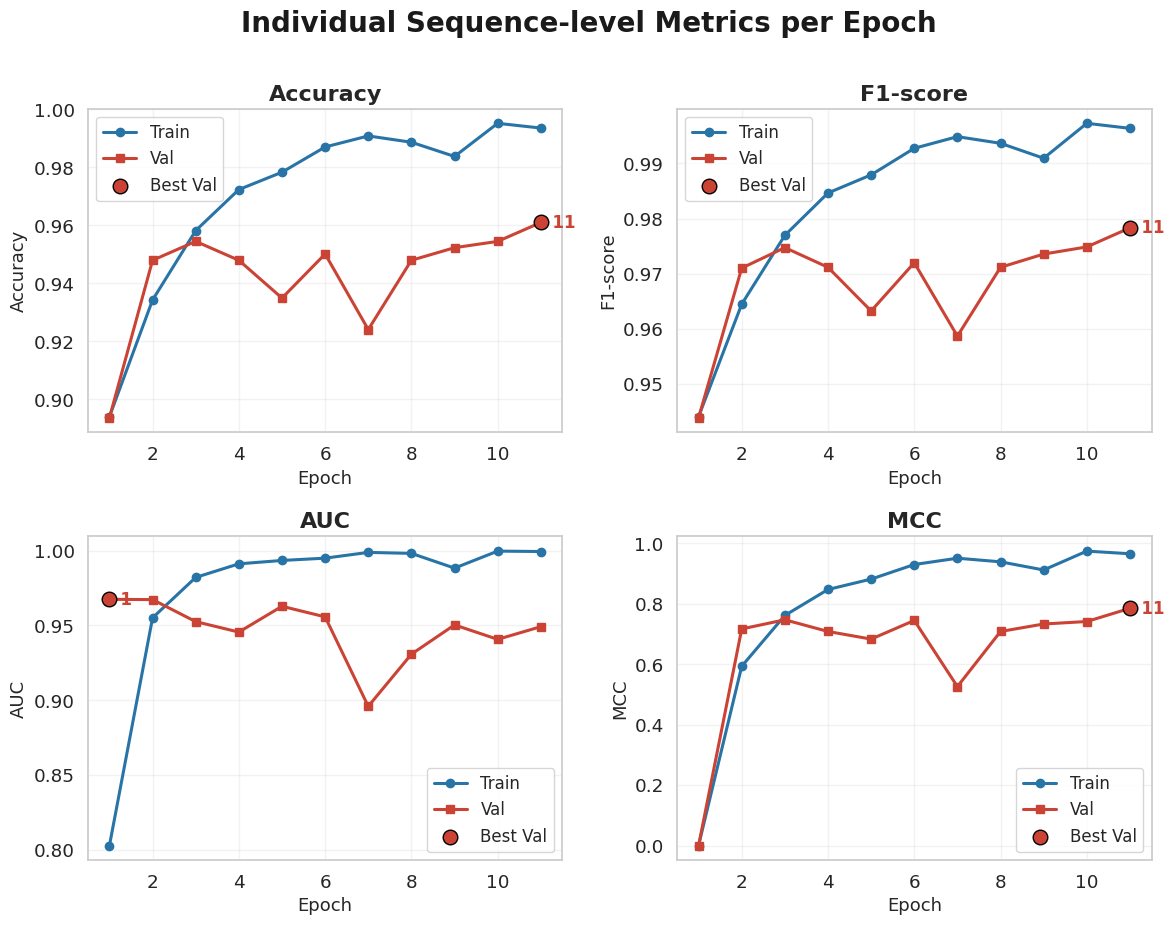

In [18]:
# ---------- 1. 단일 얼굴(Train/Val) ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# 6가지 지표
titles = ['Accuracy', 'F1-score', 'AUC', 'MCC', 'Recall', 'Precision']
metrics = [
    ('train_acc', 'val_acc'),
    ('train_f1', 'val_f1'),
    ('train_auc', 'val_auc'),
    ('train_mcc', 'val_mcc')
]
train_color = '#2874A6'  # 파랑
val_color = '#CB4335'    # 코랄/빨강

for idx, ax in enumerate(axes.flat):
    tr, va = metrics[idx]
    ax.plot(x, history[tr], label='Train', color=train_color, linewidth=2.2, marker='o', markersize=6)
    ax.plot(x, history[va], label='Val', color=val_color, linewidth=2.2, marker='s', markersize=6)
    ax.set_title(titles[idx], fontsize=16, weight='bold')
    ax.set_xlabel('Epoch', fontsize=13)
    ax.set_ylabel(titles[idx], fontsize=13)
    ax.grid(alpha=0.25)
    # Best epoch marker
    best_idx = np.argmax(history[va]) if 'loss' not in va else np.argmin(history[va])
    ax.scatter(x[best_idx], history[va][best_idx],
               color=val_color, s=110, edgecolor='black', label='Best Val', zorder=5)
    ax.legend(fontsize=12, loc='best')
    # Best epoch 번호
    ax.text(x[best_idx], history[va][best_idx], f"  {best_idx+1}", va='center', fontsize=12, color=val_color, weight='bold')
plt.suptitle("Individual Sequence-level Metrics per Epoch", fontsize=20, y=1.03, color='#1a1a1a', weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

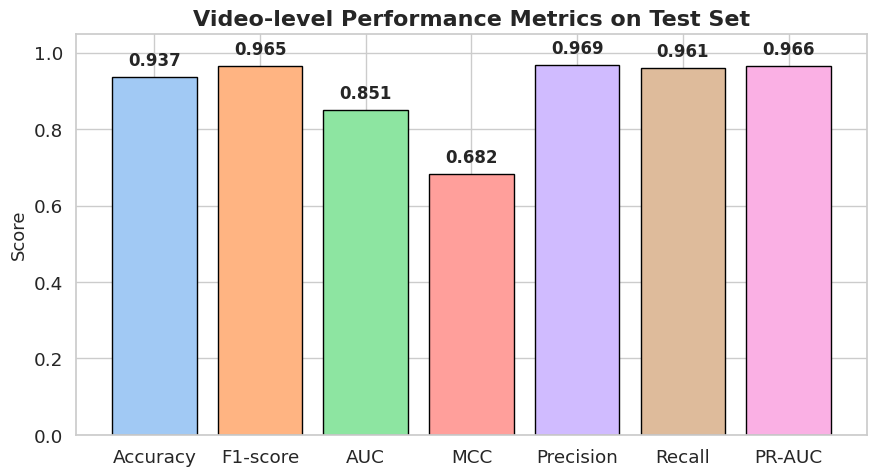

In [19]:
# ---------- 2. 다중 얼굴 비디오 레벨(테스트) ----------
# 테스트(비디오 level) 성능지표 딕셔너리로 정리
test_metrics = {
    "Accuracy": video_acc,
    "F1-score": video_f1,
    "AUC": video_auc,
    "MCC": video_mcc,
    "Precision": video_prec,
    "Recall": video_rec,
    "PR-AUC": video_prc,
}

colors = sns.color_palette("pastel")[:len(test_metrics)]  # 자동 예쁜 색상

plt.figure(figsize=(9, 5))
bars = plt.bar(test_metrics.keys(), test_metrics.values(), color=colors, edgecolor='black')
plt.ylim(0, 1.05)
plt.title("Video-level Performance Metrics on Test Set", fontsize=16, weight='bold')
plt.ylabel("Score", fontsize=13)

# 수치 표기
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02,
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

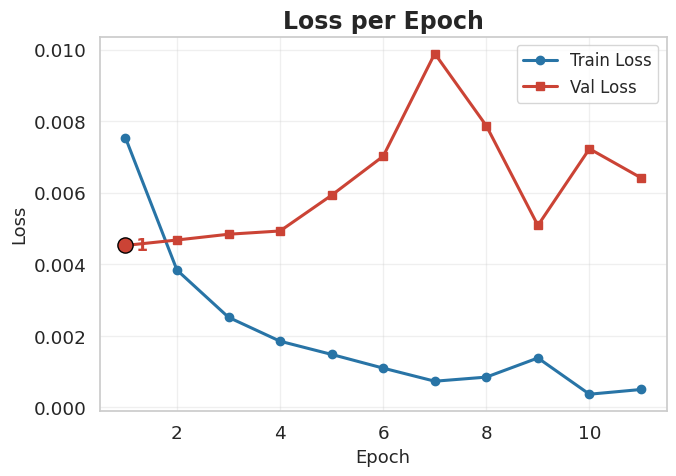

In [20]:
# ---------- 3. (옵션) Loss 따로 시각화 ----------
plt.figure(figsize=(7, 5))
plt.plot(x, history['train_loss'], label='Train Loss', color=train_color, linewidth=2.2, marker='o', markersize=6)
plt.plot(x, history['val_loss'], label='Val Loss', color=val_color, linewidth=2.2, marker='s', markersize=6)
plt.title('Loss per Epoch', fontsize=17, weight='bold')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
# Best val loss
best_idx = np.argmin(history['val_loss'])
plt.scatter(x[best_idx], history['val_loss'][best_idx],
            color=val_color, s=120, edgecolor='black', label='Best Val Loss', zorder=5)
plt.text(x[best_idx], history['val_loss'][best_idx], f"  {best_idx+1}", va='center', fontsize=12, color=val_color, weight='bold')
plt.tight_layout()
plt.show()

## 혼동행렬

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

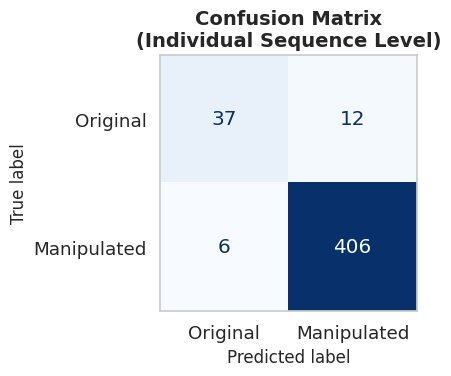

In [22]:
# ---------- 1. 단일 얼굴(Train/Val) ----------

# 예측값 및 타깃은 마지막 validation 루프에서 저장되어 있어야 함
# preds, targets 변수는 validation 루프에서 나옴 (sequence-level)

val_pred_label = [1 if p > 0.5 else 0 for p in preds]  # 예측확률 사용 시
cm_seq = confusion_matrix(targets, val_pred_label)
disp = ConfusionMatrixDisplay(cm_seq, display_labels=['Original', 'Manipulated'])

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix\n(Individual Sequence Level)", fontsize=14, weight='bold')
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

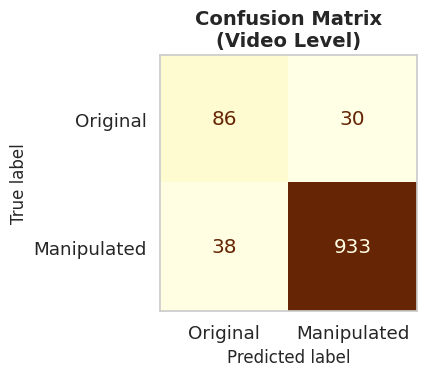

In [23]:
# ---------- 2. 다중 얼굴 비디오 레벨(테스트) ----------
cm_video = confusion_matrix(video_targets, video_preds)
disp_video = ConfusionMatrixDisplay(cm_video, display_labels=['Original', 'Manipulated'])

plt.figure(figsize=(5, 4))
disp_video.plot(cmap='YlOrBr', ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix\n(Video Level)", fontsize=14, weight='bold')
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

## 오분류 샘플

In [24]:
# ---------- 1. 단일 얼굴(Train/Val) ----------

# preds, targets, val_video_ids, val_face_idxs가 validation 루프에서 저장되어야 함
# preds: 시퀀스별 예측(0/1), targets: 시퀀스별 실제값
# val_video_ids, val_face_idxs: 각 샘플의 비디오ID, 얼굴인덱스

mis_idx = [i for i, (t, p) in enumerate(zip(targets, preds)) if t != p]
# (video_id, face_idx, 실제정답, 예측값) 튜플로 정리
misclassified = [
    (val_video_ids[i], val_face_idxs[i], targets[i], preds[i])
    for i in mis_idx
]

print(f"\n[개별 시퀀스 오분류 샘플 수] {len(misclassified)} / {len(targets)}")
print("video_id, face_idx, 실제정답, 예측값")
for v_id, fidx, label, pred in misclassified[:20]:  # 앞 20개만 예시
    print(f"{v_id:30s}  {fidx:2d}  정답: {label}  예측: {pred}")


[개별 시퀀스 오분류 샘플 수] 18 / 461
video_id, face_idx, 실제정답, 예측값
13_11__podium_speech_happy__XXKQ4XM0   0  정답: 1  예측: 0
10_23__exit_phone_room__W4BDINQ5   0  정답: 1  예측: 0
09_01__walk_down_hall_angry__6TSGVLHA   0  정답: 1  예측: 0
02__outside_talking_pan_laughing   0  정답: 0  예측: 1
21_09__talking_against_wall__LBQF8ZN1   0  정답: 1  예측: 0
28__talking_angry_couch          0  정답: 0  예측: 1
02__outside_talking_still_laughing   0  정답: 0  예측: 1
26__walking_outside_cafe_disgusted   0  정답: 0  예측: 1
19__secret_conversation          0  정답: 0  예측: 1
18__walking_down_street_outside_angry   0  정답: 0  예측: 1
05__outside_talking_still_laughing   0  정답: 0  예측: 1
18__exit_phone_room              0  정답: 0  예측: 1
06_27__walking_outside_cafe_disgusted__VN14WY2N   0  정답: 1  예측: 0
03__walking_outside_cafe_disgusted   0  정답: 0  예측: 1
19__kitchen_pan                  0  정답: 0  예측: 1
07__walk_down_hall_angry         0  정답: 0  예측: 1
28__podium_speech_happy          0  정답: 0  예측: 1
26_12__outside_talking_still_laughing__FWFQ5Y

In [25]:
# ---------- 2. 다중 얼굴 비디오 레벨(테스트) ----------

# video_targets, video_preds: 비디오별 실제/예측 레이블
# video_pred_dict: {video_id: [시퀀스별 예측들]}, video_target_dict: {video_id: 실제값}

mis_idx_video = [i for i, (t, p) in enumerate(zip(video_targets, video_preds)) if t != p]
misclassified_video = [
    (list(video_pred_dict.keys())[i], video_targets[i], video_preds[i])
    for i in mis_idx_video
]

print(f"\n[비디오 레벨 오분류 샘플 수] {len(misclassified_video)} / {len(video_targets)}")
print("video_id, 실제정답, 예측값, 시퀀스별 예측")
for v_id, label, pred in misclassified_video[:20]:
    seq_preds = video_pred_dict[v_id]
    print(f"{v_id:30s}  정답: {label}  예측: {pred}  (시퀀스 예측: {seq_preds})")



[비디오 레벨 오분류 샘플 수] 68 / 1087
video_id, 실제정답, 예측값, 시퀀스별 예측
27__hugging_happy               정답: 0  예측: 1  (시퀀스 예측: [np.int64(1)])
14__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
18__walking_outside_cafe_disgusted  정답: 0  예측: 1  (시퀀스 예측: [np.int64(1)])
18__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
02__walking_and_outside_surprised  정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(1)])
23__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
03__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
02__hugging_happy               정답: 0  예측: 1  (시퀀스 예측: [np.int64(1)])
23__hugging_happy               정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
26__secret_conversation         정답: 0  예측: 1  (시퀀스 예측: [np.int64(1), np.int64(0)])
23__talking_angry_couch         정답: 0  예측: 1  (시퀀스 예측: [np.int64(0), np.int64(1)])
14__walking_and_outside_surprised  정답: 0  예측: 1  (시퀀스 예측: [np